<a href="https://colab.research.google.com/github/fastlearner-ai/WWII-USN-Carrier-Aircraft-Classifier/blob/main/Copy_of_warbird_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WWII USN Fighter Image Classifier**


This notebook scrapes pictures of the nine most important World War II USN carrier aircraft and then trains a CNN model which accurately classifies them.

In [ ]:
from pathlib import Path
path = Path().cwd()/"warbirds" #assigns path to current working directory
#These classes need to be in alphabetical order:
warbirds = ['avenger', 'bearcat', 'buffalo', 'corsair', 'dauntless', 'devastator', 'hellcat', 'helldiver', 'wildcat']

Many of these carrier planes look similar to each other. For example, they are usually colored some shade of blue. They are all single-engine monoplane naval aircraft from the same navy and same timeframe.

In particular, many of the fighter aircraft can appear similar even to a human:

-The **F2A Buffalo** looks much tubbier than any of the others, but still looks similar to the **F4F Wildcat** from some angles.

-The **F4F Wildcat** looks very similar to its successor the **F6F Hellcat**. I expect the model to confuse these two the most frequently.

-The **F6F Hellcat** looks similar to its own successor the **F8F Bearcat**.

# Data collection (DuckDuckGo image scraping):

In [ ]:
#import the image scraper by @JoeDockrill, website: https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/
!pip install -q jmd_imagescraper
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *

num_images = 25 #Total number of images per class we are scraping

In [ ]:
#Scrape images; these commands do not necessarily need to be in alphabetical order because they produce the same folder structure regardless.
duckduckgo_search(path,"avenger","tbf avenger",max_results=num_images);
duckduckgo_search(path,"bearcat","f8f bearcat",max_results=num_images);
duckduckgo_search(path,"buffalo","f2a buffalo",max_results=num_images);
duckduckgo_search(path,"corsair","f4u corsair",max_results=num_images);
duckduckgo_search(path,"dauntless","sbd dauntless",max_results=num_images);
duckduckgo_search(path,"devastator","tbd devastator",max_results=num_images);
duckduckgo_search(path,"hellcat","f6f hellcat",max_results=num_images);
duckduckgo_search(path,"helldiver","sb2c helldiver",max_results=num_images);
duckduckgo_search(path,"wildcat","f4f wildcat",max_results=num_images);


In [ ]:
#@title Code to delete pictures in case you mess up:
#Utility code to delete folders if necessary:
import shutil
shutil.rmtree('/content/warbirds')
shutil.rmtree('/content/warbirds_processed')

# Data Cleaning (Auto-remove near duplicates, manually remove incorrectly-labeled data):

In [ ]:
!pip install fiftyone
!pip install torch torchvision
!pip install sklearn
import fiftyone as fo
import fiftyone.zoo as foz
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
#Create fiftyone model:
dataset = fo.Dataset.from_dir(path, dataset_type=fo.types.ImageClassificationDirectoryTree)
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = dataset.compute_embeddings(model)
print(embeddings.shape)

similarity_matrix = cosine_similarity(embeddings)
print(similarity_matrix.shape)
print(similarity_matrix)

#Every single picture is a perfect match with itself, but we want to ignore that fact.
#So we subtract the  identity matrix from similarity matrix so main diagonal values are 0 instead of 1:
n = len(similarity_matrix)
similarity_matrix = similarity_matrix - np.identity(n)

id_map = [s.id for s in dataset.select_fields(["id"])]
#filepath_map = [f.filepath for f in dataset.select_fields(["filepath"])]
for idx, sample in enumerate(dataset):
    sample["max_similarity"] = similarity_matrix[idx].max()
    sample.save()

In [ ]:
print(filepath_map)
print(len(filepath_map))

In [ ]:
#(to look at the unsorted data)
#session = fo.launch_app(dataset) 

#Look at image data via FiftyOne applet, sorted by max_similartiy (descending)
view = dataset.sort_by("max_similarity", True)
session = fo.launch_app(view=view)

In [ ]:
import os
thresh = 0.93
samples_to_remove = set()
#filepaths_to_remove = set()
samples_to_keep = set()
for idx, sample in enumerate(dataset):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        #print(sample.id)
        
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            #print(dup)
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])
            #filepaths_to_remove.add(filepath_map[dup])
        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()
        
    else:
        sample.tags.append("duplicate")
        sample.save()
        
# If you want to remove the samples from the dataset entirely 
#Deprecated: 
dataset.remove_samples(list(samples_to_remove))
#print(list(samples_to_remove))
#print(id_map[58])
#dataset.delete_samples(list(samples_to_remove))
#print(filepaths_to_remove)
#            os.remove(filepath_map[dup])
#for filepath in filepaths_to_remove:
#    os.remove(filepath)
#print(filepaths_to_remove)

In [ ]:
#Image cleaner provided by jmd_imagescraper
#Manually search thru images to delete wrong examples:
display_image_cleaner(path)

In [ ]:
#@title Alternative: use FastAI images cleaner instead
#Or if you prefer you can use FastAI's cleaner instead; it takes a long time to load the images though.
#Also, properly importing these libraries may require a runtime restart in Colab!
"""
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

files = get_image_files(path)
w = ImagesCleaner(max_n=400)
w.set_fns(files)
w
"""

# Set aside some data for Validation and Training sets:

In [ ]:
#Splitfolders takes random samples and places them in separate train and test folders:
!pip install split_folders
import splitfolders
input_folder = "/content/warbirds"
output_folder = "/content/warbirds_processed"

#ratio is train/val/test:
splitfolders.ratio(input_folder, output_folder, seed=22, ratio=(0.7,0.15,0.15))

Copying files: 225 files [00:00, 4430.62 files/s]


In [ ]:
#@title Alternative: Manually split data into train/test folders
#CODE TO MANUALLY SELECT A RANDOM SAMPLE TO SEND TO THE TESTING FOLDER;
#(KERAS DOES NOT PROVIDE A WAY TO EASILY SPLIT TRAINING AND TESTING DATA FOR SOME REASON)
"""
os.mkdir('/content/warbirds_processed')
os.mkdir('/content/warbirds_processed/bearcat')
os.mkdir('/content/warbirds_processed/buffalo')
os.mkdir('/content/warbirds_processed/corsair')
os.mkdir('/content/warbirds_processed/hellcat')
os.mkdir('/content/warbirds_processed/wildcat')

import numpy as np
import os

folders = ['bearcat', 'buffalo', 'corsair', 'hellcat', 'wildcat']
for folder in folders:
  # list all files in dir
  files = [f for f in os.listdir('/content/warbirds/' + folder)]
  # select 0.15 of the files randomly 
  random_files = np.random.choice(files, int(len(files)*.15), replace=False)
  source = '/content/warbirds/' + folder
  for num, random_file in enumerate(random_files):
    os.replace(source + "/"+ random_file,"/content/warbirds_processed" + "/" + folder + random_file)
"""

# Building the model:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [ ]:
#Params:
img_height, img_width = (128, 128)
batch_size = 32
num_epochs = 11
lr = 5E-4 #default for Adam is 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
train_data_dir = "/content/warbirds_processed/train"
valid_data_dir = "/content/warbirds_processed/val"
test_data_dir = "/content/warbirds_processed/test"

In [ ]:
#Create data generators and show classes:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split = 0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training")

valid_generator= train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation")

test_generator= train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1, #in order to test one at a time
    class_mode="categorical",
    subset="validation")

train_generator.classes

Found 99 images belonging to 9 classes.
Found 9 images belonging to 9 classes.
Found 18 images belonging to 9 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

#Last minute check on our data before we train:

In [ ]:
#Verify image and class list tensor shapes:
x,y = test_generator.next()
x.shape, y.shape, train_generator.num_classes
#['bearcat', 'buffalo', 'corsair', 'hellcat', 'wildcat']

In [ ]:
#Create the base CNN:
res_model = ResNet50(include_top=False, weights='imagenet') #input_tensor=None

#Add dense layers at front and softmax at end for prediction/classification:
x = res_model.output
x = GlobalAveragePooling2D()(x) #puts another layer in front of x
x = Dense(1024, activation='relu')(x) #""
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=res_model.input, outputs=predictions)

#Freeze CNN layers to non-trainable (we don't want to train these!):
for layer in res_model.layers:
  layer.trainable = False


In [ ]:
x

In [ ]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #optimizer='adam'

In [ ]:
#tf.keras.preprocessing.image.array_to_img(image[0]).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


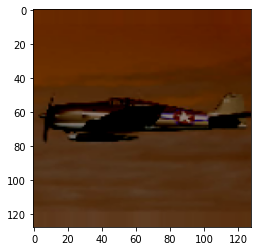

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
#Show example testing image:
from PIL import Image
#from tensorflow.keras.preprocessing import image
for i in range(0,1):
  image = x[i]
  #print(image)
  plt.imshow(np.array(image, dtype=np.int32))
  plt.show()
y

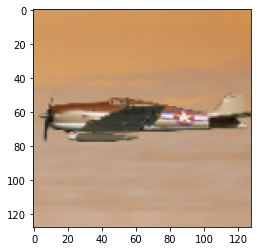

In [ ]:
#@title Alternative code to show image through tensorflow:
#Alternative image view:

from PIL import Image
from tensorflow.keras.preprocessing import image
import tensorflow.keras.utils
#x.shape
img = x[0,:,:]
img.shape
for i in range(0,1):
  img = tf.keras.preprocessing.image.array_to_img(img)
  plt.imshow(img)
  plt.show()


#Compile, Train and Save model:

In [ ]:
print(model.summary())

In [ ]:
#Train the model on the training data:
train_history = model.fit(train_generator, epochs=num_epochs, validation_data = valid_generator, verbose=2)

In [ ]:
model.save("/content/warbirds/ResNet50_Warbirds.hdf5");

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Calculating and visualizing accuracy: 

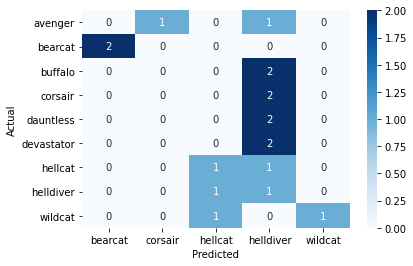

In [ ]:
#Confusion Matrix
#tutorial which helped me: https://www.youtube.com/watch?v=1Gbcp66yYX4
import pandas as pd
import seaborn as sn

model = tf.keras.models.load_model("/content/warbirds/ResNet50_Warbirds.hdf5")
filenames = test_generator.filenames
samples_num = len(test_generator) # len(warbirds)
y_prob = []
y_act = []
test_generator.reset()

for i in range(samples_num):
  X_test, Y_test = test_generator.next()
  result = model.predict(X_test)
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)
  res = result[0]
  res.sort()
  res = res[::-1]
  prob = res[:3]
  #print(prob)

predicted_class = [list(train_generator.class_indices.keys())[j.argmax()] for j in y_prob]
actual_class = [list(train_generator.class_indices.keys())[j.argmax()] for j in y_act]
out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()

In [ ]:
model.evaluate(X_test, Y_test)

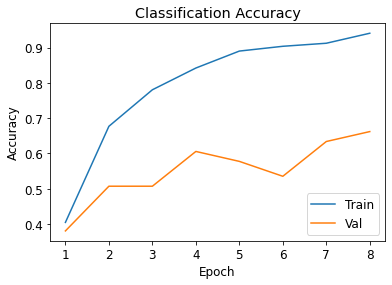

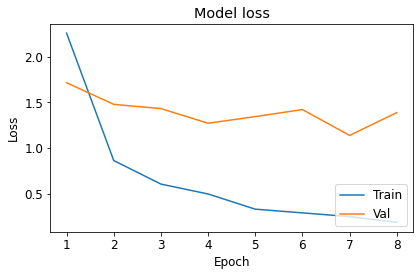

In [ ]:
#Plot accuracy/loss vs epochs for train/validation datasets:

#Accuracy:
epoch_range = range(1, num_epochs+1)
plt.plot(epoch_range, train_history.history['accuracy'])
plt.plot(epoch_range, train_history.history['val_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

#Loss
plt.plot(epoch_range,train_history.history['loss'])
plt.plot(epoch_range, train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.tight_layout()

# New Section

In [ ]:
#Improve:
#Add more pics?
#Cross validation, optimize hyperparamaters